# Correlation with clinical outcome

The evaluation of the merged Palma-Ikonomi models focuses on their ability to predict clinical outcomes for patients with specific mutations. Palma et al. has connected their network to three cancer hallmark phenotypes: apoptosis, differentiation and proliferation. In addition, an integrated network score was defined as subtracting the value of apoptosis and differentiation from the value of the proliferation to reflect the malignancy of the cancer. The phenotype scores were then used as a proxy of the prediction power of the model to patients’ clinical outcomes.

In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [9]:
merged_and_name = "../Models/merged_and_" + model1name + "_" + model2name
merged_inhibitor_wins_name = "../Models/merged_inhibitor_wins_" + model1name + "_" + model2name
merged_or_name = "../Models/merged_or_" + model1name + "_" + model2name

# load the network
merged_and = boolnet.loadNetwork(merged_and_name + ".txt")
merged_inhibitor_wins = boolnet.loadNetwork(merged_inhibitor_wins_name + ".txt")
merged_or = boolnet.loadNetwork(merged_or_name + ".txt")

# get the attractor states
attr_and = boolnet.getAttractors(merged_and)
attr_inhibitor_wins = boolnet.getAttractors(merged_inhibitor_wins)
attr_or = boolnet.getAttractors(merged_or)

## Validation against previous Palma 2021 results
### Harzard ratio for death
>We next evaluated whether we could use these models to infer some clinical outcomes of patients carrying mutations in NPM1 and/or DNMT3A and/or FLT3. To this end we made use of the clinical information provided by Papaemmanuil et al. reporting the impact of somatic mutations on overall survival and we compared the mutation-specific hazard ratios with the predictions of our models. As a proxy for the predictive power of our model, we defined the “integrated network phenotype” score, which is calculated by subtracting from the activation value of the phenotype “proliferation” the values of “apoptosis” and “differentiation”.

In [28]:
def simulation(model_file):
    model = biolqm.load(model_file)
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["wt","flt3","npm1","dnmt3a","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_npm1_dnmt3a"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results

def hazard_ratio_pc(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio,simulation_results])
    
    phenotypes = ['NETWORK', 'APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']
    hazard_ratio_pc_results = pd.DataFrame()
    
    for phenotype in phenotypes:
        # Extract hazard ratio and phenotype values
        x = results.loc['Hazard_ratio', :]
        y = results.loc[phenotype, :]
        
        # Calculate Pearson Correlation and p-value
        hazard_ratio_pc_results.loc[phenotype, 'pc'], hazard_ratio_pc_results.loc[phenotype, 'p_value'] = pearsonr(x, y)
    return hazard_ratio_pc_results
    

def hazard_ratio_plot(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio, simulation_results])
    
    # Plotting scatterplots
    phenotypes = ['NETWORK', 'APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for i, phenotype in enumerate(phenotypes):
        ax = axes[i // 2, i % 2]
        # Extract hazard ratio and phenotype values
        y = results.loc['Hazard_ratio', :]
        x = results.loc[phenotype, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{phenotype} vs Hazard Ratio for Death')
        ax.set_ylabel('Hazard Ratio')
        ax.set_xlabel(phenotype)
    
        # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
        
        # Annotate Pearson Correlation and p-value
        if phenotype in ['APOPTOSIS', 'DIFFERENTIATION']:
            ax.text(0.05, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                    transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom')
        else:
            ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                    transform=ax.transAxes, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

def hazard_ratio_plot_network(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio, simulation_results])
    
    # Plotting scatterplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Extract hazard ratio and phenotype values
    y = results.loc['Hazard_ratio', :]
    x = results.loc['NETWORK', :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title('Hazard Ratio for Death vs Network score')
    ax.set_ylabel('Hazard Ratio for Death')
    ax.set_xlabel('Network score')

    # Annotate each data point
    for j in range(len(x)):
        label = x.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

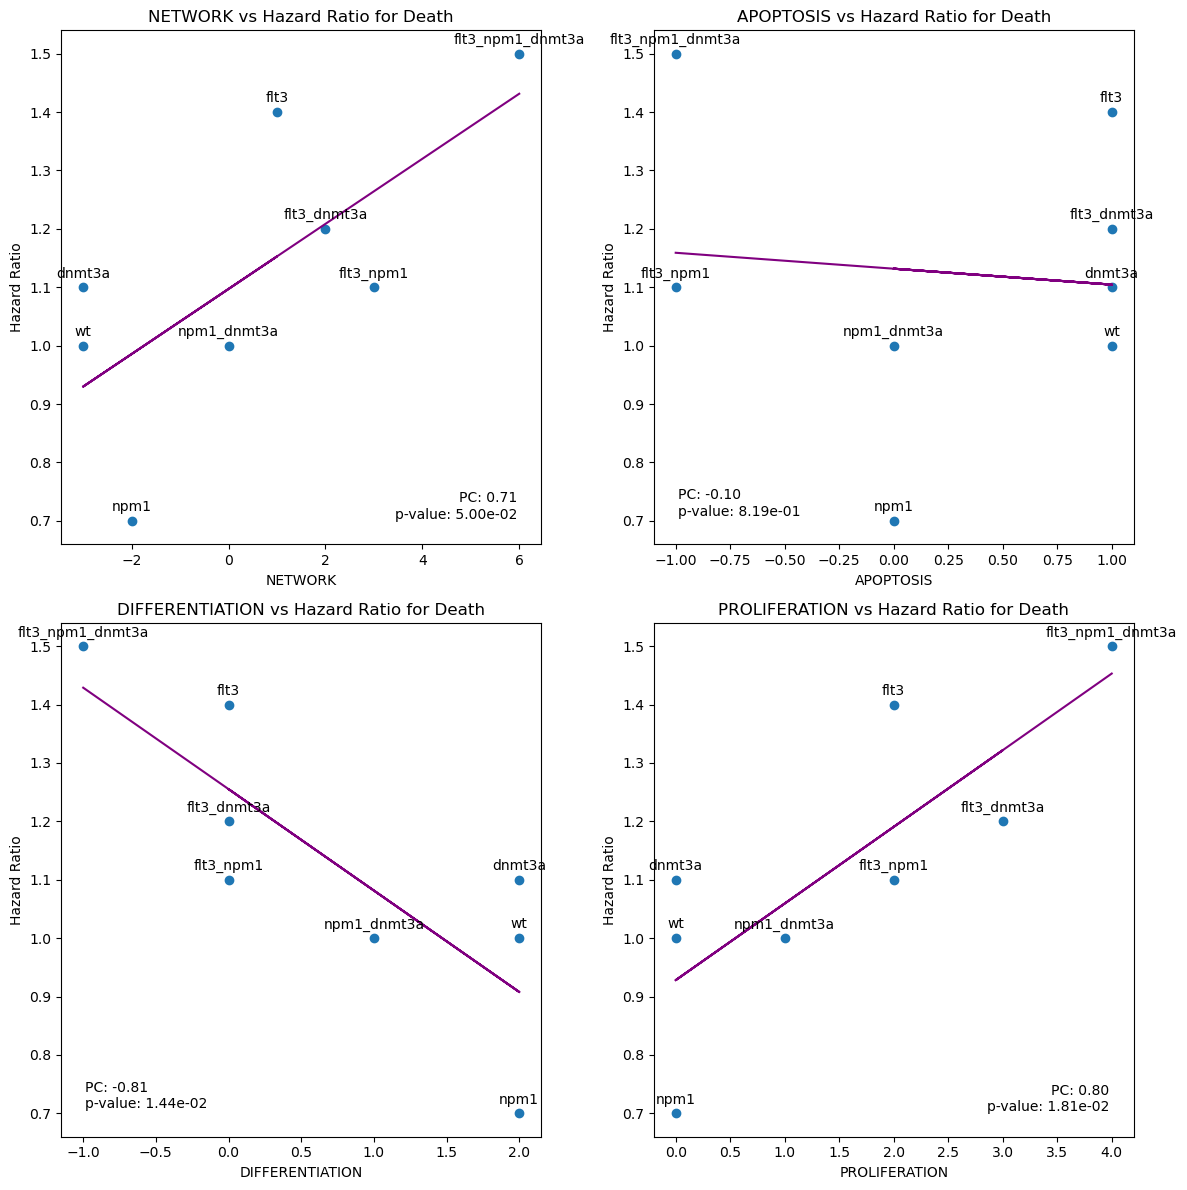

In [29]:
# Palma 2021's results
simulation_results_palma = simulation('Palma2021_nophe.sbml')
hazard_ratio_pc_palma = hazard_ratio_pc(simulation_results_palma, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_palma, 'Hazard Ratio for Death.csv')

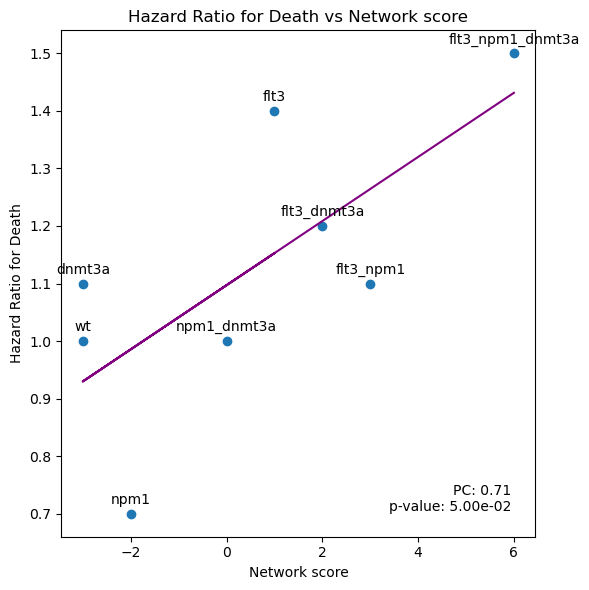

In [27]:
hazard_ratio_plot_network(simulation_results_palma, 'Hazard Ratio for Death.csv')

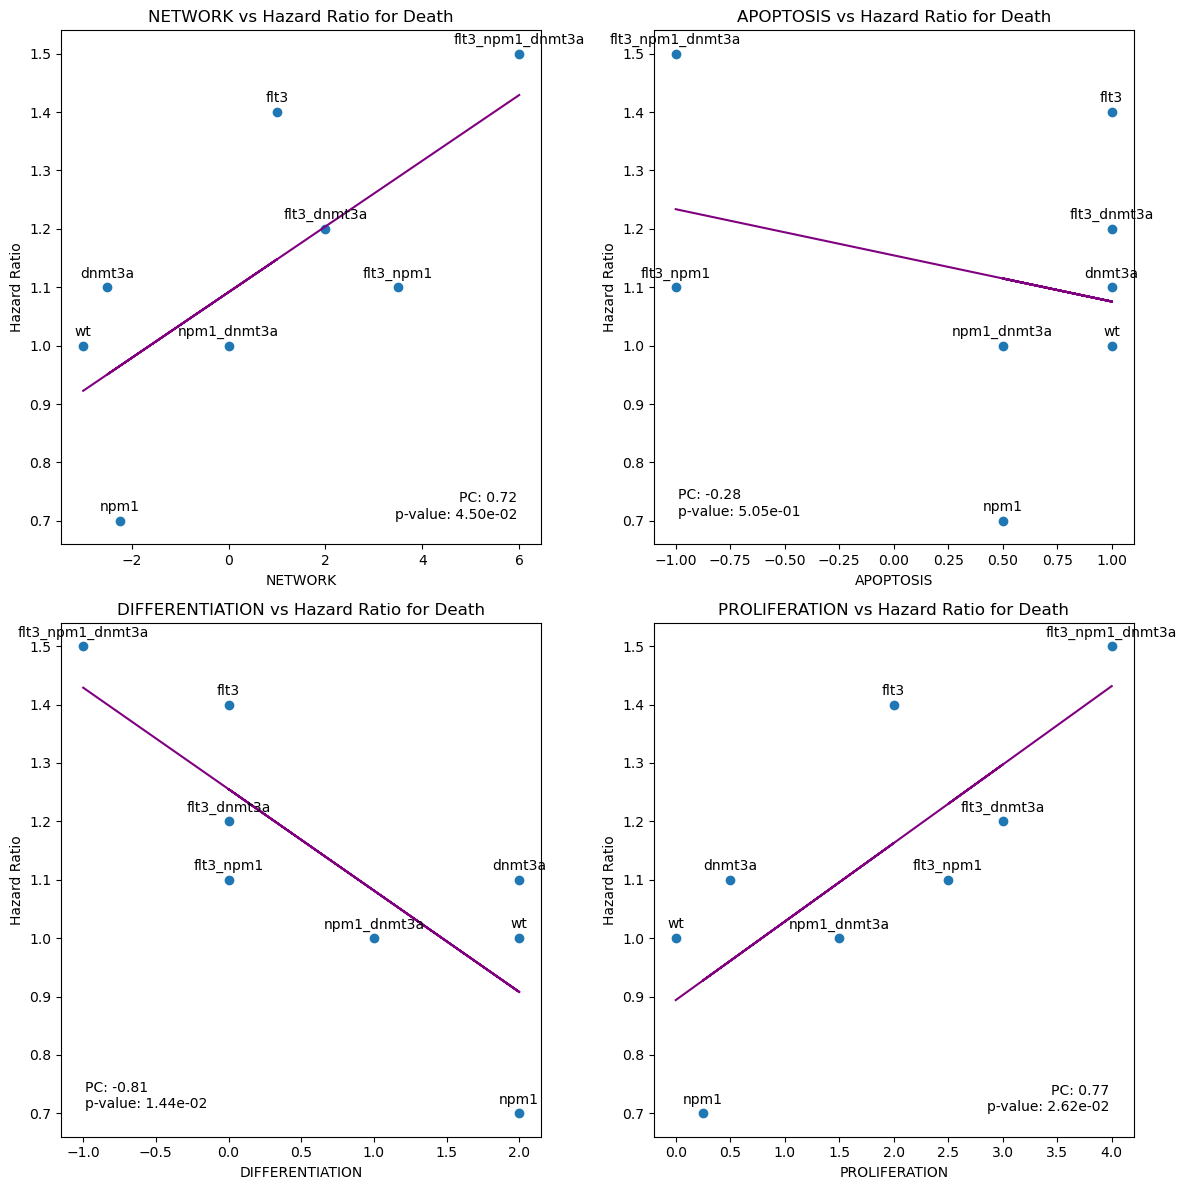

In [31]:
# Merged rules using 'OR'
simulation_results_or = simulation('merged_or.sbml')
hazard_ratio_pc_or = hazard_ratio_pc(simulation_results_or, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_or, 'Hazard Ratio for Death.csv')

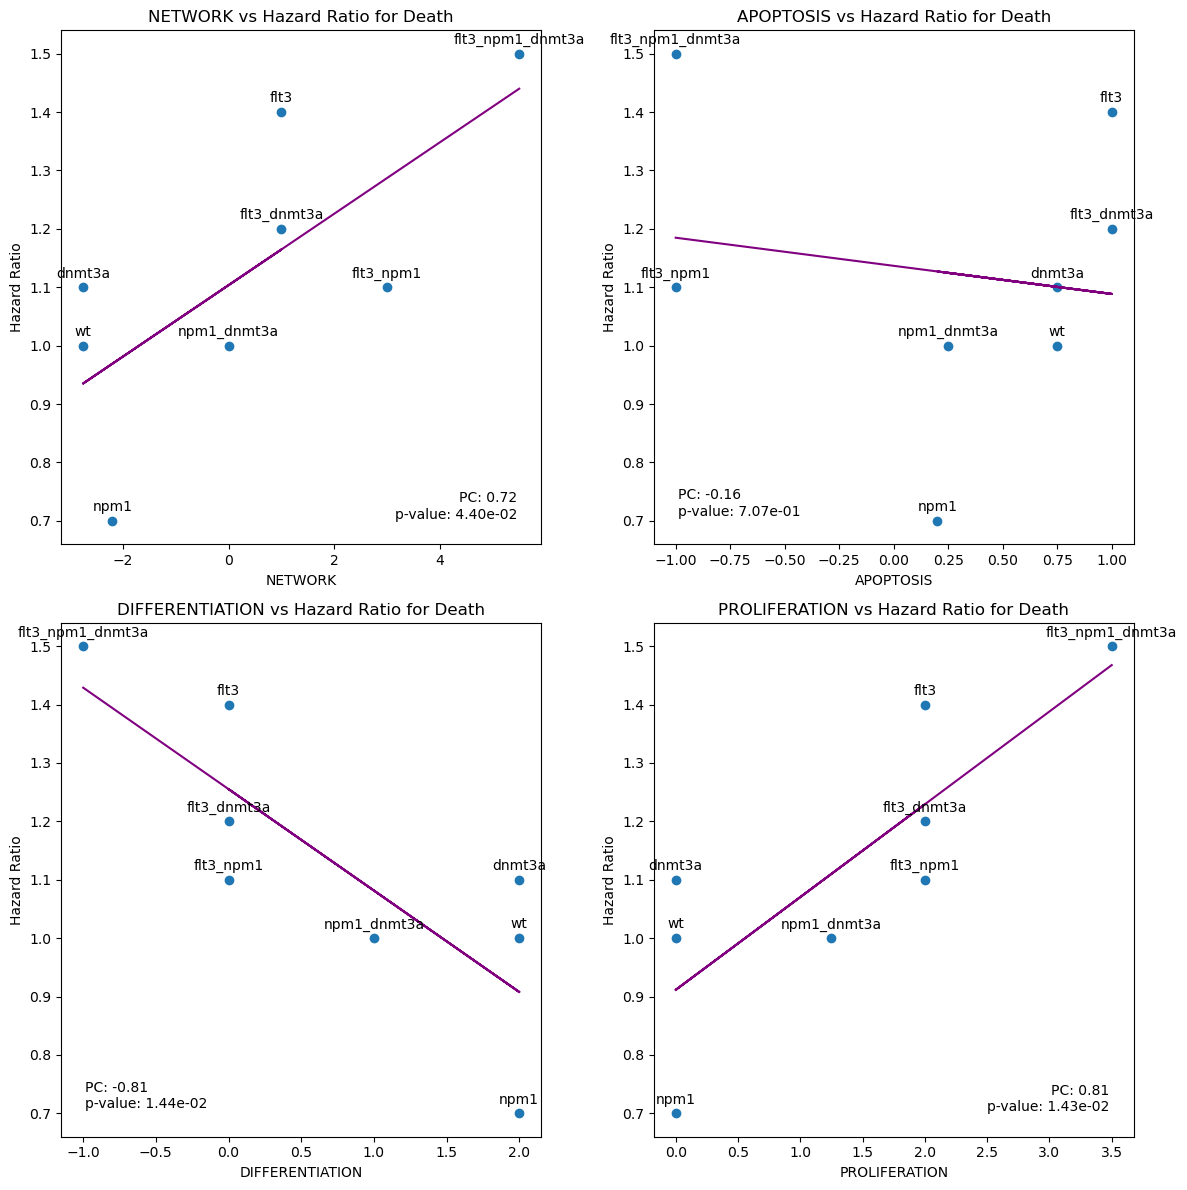

In [32]:
# Merged rules using 'Inhibitor wins'
simulation_results_inhibitor_wins = simulation('merged_inhibitor_wins.sbml')
hazard_ratio_pc_inhibitor_wins = hazard_ratio_pc(simulation_results_inhibitor_wins, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_inhibitor_wins, 'Hazard Ratio for Death.csv')

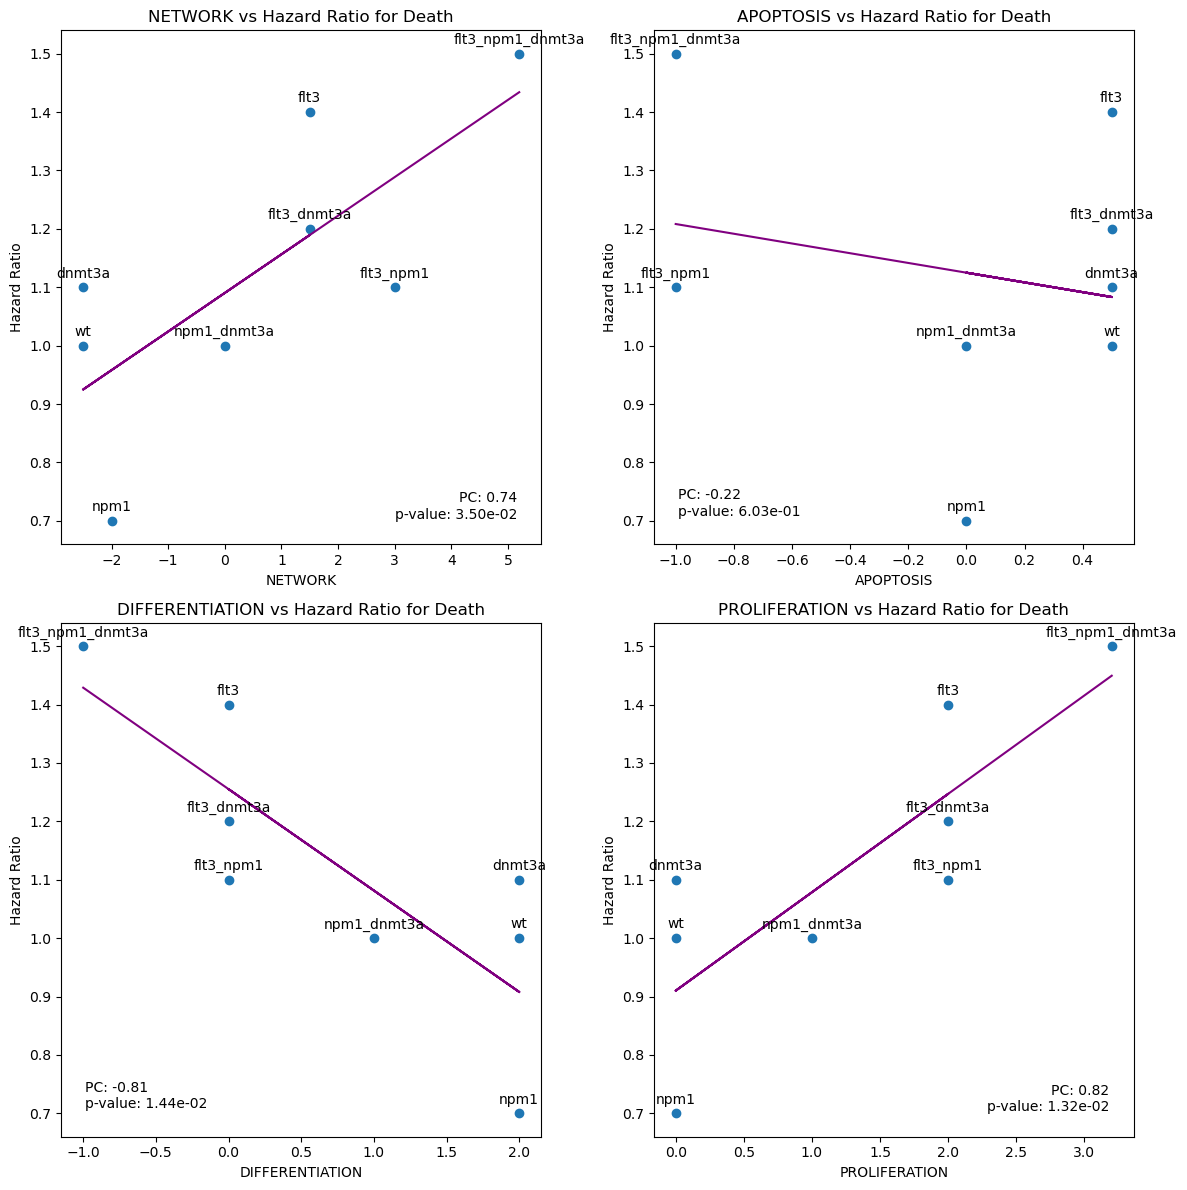

In [33]:
# Merged rules using 'AND'
simulation_results_and = simulation('merged_and.sbml')
hazard_ratio_pc_and = hazard_ratio_pc(simulation_results_and, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_and, 'Hazard Ratio for Death.csv')

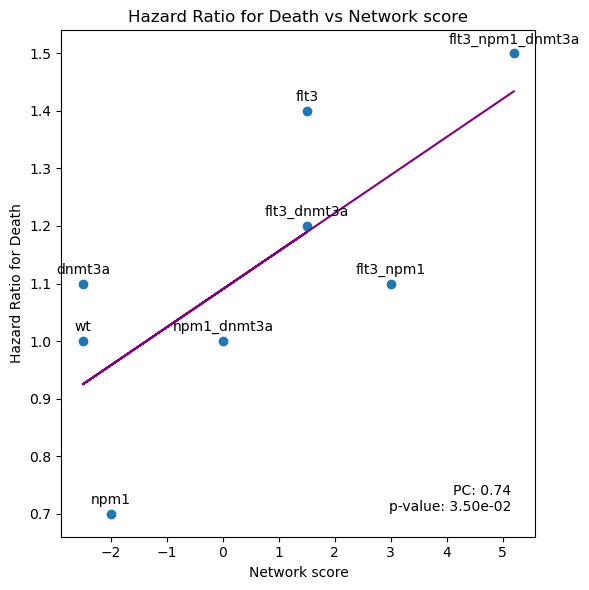

In [34]:
hazard_ratio_plot_network(simulation_results_and, 'Hazard Ratio for Death.csv')

In [43]:
# Display the results side by side
from IPython.display import display_html
def display_side_by_side(dfs: list, titles: list):
    """Display dataframes side by side with titles"""
    html_str = ''
    for df, title in zip(dfs, titles):
        df_html = df.to_html()
        df_html = df_html.replace('<table border="1" class="dataframe">', 
                                  f'<table border="1" class="dataframe" style="display:inline;margin-right:20px;"><caption style="text-align:center;font-weight:bold">{title}</caption>')
        html_str += df_html
    display_html(html_str, raw=True)

titles = ['Palma', 'OR', 'Inhibitor Wins', 'AND']
display_side_by_side([hazard_ratio_pc_palma, hazard_ratio_pc_or, hazard_ratio_pc_inhibitor_wins, hazard_ratio_pc_and], titles=titles)


,pc,p_value
NETWORK,0.706758,0.049989
APOPTOSIS,-0.096976,0.819306
DIFFERENTIATION,-0.811666,0.014430
PROLIFERATION,0.796003,0.018109
,pc,p_value
NETWORK,0.717688,0.045013
APOPTOSIS,-0.277943,0.505075
DIFFERENTIATION,-0.811666,0.014430
PROLIFERATION,0.767542,0.026183
,pc,p_value


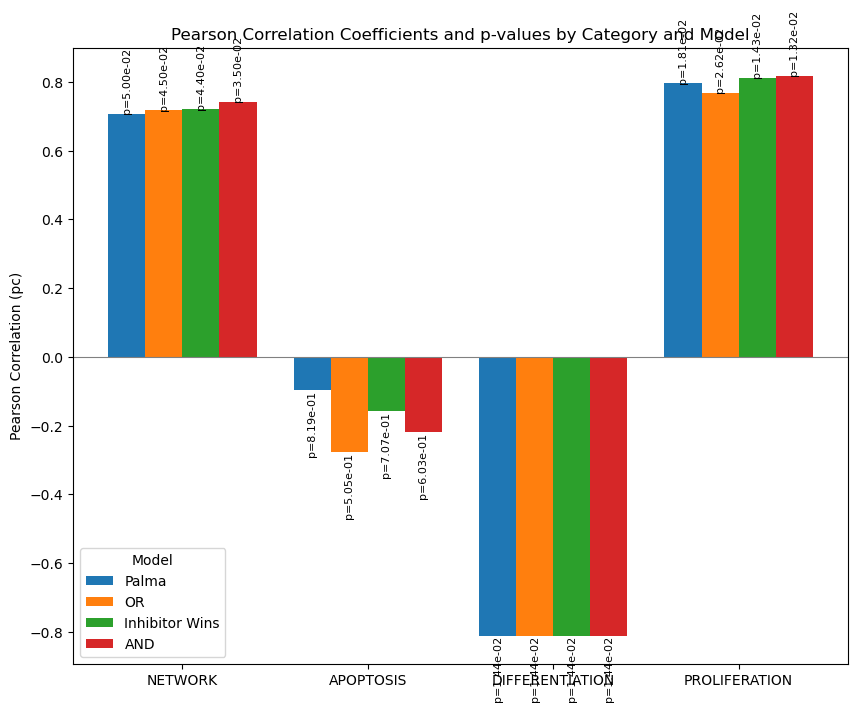

In [131]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = hazard_ratio_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

def plot_df(df, ax, position, label):
    bars = ax.bar(x + position * width, df['pc'], width, label=label)
    # Annotate p-value on each bar
    for bar, p_value in zip(bars, df['p_value']):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'p={p_value:.2e}', 
                ha='center', va='bottom' if bar.get_height() > 0 else 'top', fontsize=8, rotation=90)

# Plot each dataframe
plot_df(hazard_ratio_pc_palma, ax, -1.5, 'Palma')
plot_df(hazard_ratio_pc_or, ax, -0.5, 'OR')
plot_df(hazard_ratio_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(hazard_ratio_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values by Category and Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

**The phenotype scores correlate significantly with the death hazard ratio, which higher correlations and more significant p-values compared with the results from the Palma model alone.**   